# Setup (Remote Env)
These steps are needed for running in remote environment such as Google Colab. Instructions for running in local environments are in the top level README
### Step 1
In terminal run:
```
git clone https://github.com/jordanIAxelrod/MaterialsGenomeInitiative.git
```
You will need to enter your github email and a personal access token to clone

### Step 2

Upload `train.tsv` and `test.tsv` to the data directory 

In [1]:
# Ignore this block if running locally
!pip install transformers

%cd /content/MaterialsGenomeInitiative/src

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/MaterialsGenomeInitiative/src


# Imports

In [2]:
# ML
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers

from torch.utils.data import Dataset, DataLoader
from torch import cuda
from transformers import RobertaModel, RobertaTokenizer

# utils
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm

from sklearn.metrics import confusion_matrix, f1_score


# local
import Tokenizer
import sentence_level_preprocess as slp
import word_level_preprocess as wlp



## Tokenize text from previous main

In [3]:
train_path = '../data/train.tsv'
test_path = '../data/test.tsv'
train = pd.read_csv(train_path, sep='\t')
test = pd.read_csv(test_path, sep='\t')
train.text = train.text.apply(slp.rm_linebreaks).apply(slp.c2temp_2).apply(Tokenizer.tokenize_text).apply(lambda x: list(map(wlp.c2temp, x)))
test.text = test.text.apply(slp.rm_linebreaks).apply(slp.c2temp_2).apply(Tokenizer.tokenize_text).apply(lambda x: list(map(wlp.c2temp, x)))
train.head()

,text,label
0,"[nano, composites, were, prepared, by, dispers...",action
1,"[In, this, process, ,, the, magnetic, stirring...",action
2,"[This, coating, heating, cycle, was, repeated,...",action
3,"[Four, different, soaking, temperatures, were,...",action
4,"[The, fractured, crosssections, of, the, sampl...",action


# Roberta Training and Tokenizer Configs

In [4]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
LEARNING_RATE = 1e-05
NUM_CLASSES = 4
tokenizer = RobertaTokenizer.from_pretrained('roberta-large', truncation=True, do_lower_case=True)

labels_idx = {
  'action': 0,
  'constituent': 1,
  'unrelated': 2,
  'property': 3,
}
labels_idx_rev = {
  idx: label
  for label, idx in labels_idx.items()
}

# Roberta Dataset Class

In [5]:
class ArticleDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = df
        self.text = self.data.text
        self.targets = self.data.label.map(labels_idx)
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = " ".join(self.text[index])

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

train_set = ArticleDataset(train, tokenizer, MAX_LEN)
test_set = ArticleDataset(test, tokenizer, MAX_LEN)
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(train_set, **train_params)
testing_loader = DataLoader(test_set, **test_params)

# Roberta Sequence Labeling Wrapper

In [6]:
class RobertaClass(torch.nn.Module):
    def __init__(self, hidden_dim=1024, dropout=0.3):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-large")
        self.pre_classifier = torch.nn.Linear(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(hidden_dim, 4)

    def forward(self, input_ids, attention_mask, token_type_ids):
        roberta_out = self.roberta(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids,
        )
        hidden_state_pool = roberta_out[0][:, 0]
        pre_cls_out = self.pre_classifier(hidden_state_pool)
        return self.classifier(self.dropout(F.relu(pre_cls_out)))


model = RobertaClass()
if cuda.is_available():
  model.cuda()
else:
  raise Exception()

device = 'cuda' if cuda.is_available() else 'cpu'

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# Creating the loss function and optimizer
EPOCHS = 14
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer, 0.1 * EPOCHS * len(training_loader), EPOCHS * len(training_loader))

def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct


def train_roberta(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    y_pred = []
    y_actual = []
    model.train()
    for data in tqdm.notebook.tqdm(training_loader):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.long)

      outputs = model(ids, mask, token_type_ids)
      loss = loss_function(outputs.reshape(-1, NUM_CLASSES), targets)
      tr_loss += loss.item()
      big_val, big_idx = torch.max(outputs.reshape(-1, NUM_CLASSES), dim=1)
      n_correct += calcuate_accuracy(big_idx, targets)
      y_pred += big_idx.tolist()
      y_actual += targets.tolist()


      nb_tr_steps += 1
      nb_tr_examples+=targets.size(0)

      optimizer.zero_grad()
      loss.backward()
      # # When using GPU
      optimizer.step()
      scheduler.step()

    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    epoch_f1 = f1_score(y_actual, y_pred, average='weighted')
    print(f"Epoch {epoch}")
    print(f"Training Loss: {epoch_loss}")
    print(f"Training Accuracy: {epoch_accu}")
    print(f"Training F1: {epoch_f1}")

    return epoch_accu, epoch_loss


max_acc = 0
for epoch in range(EPOCHS):
    e_acc, _  = train_roberta(epoch)
    if e_acc > max_acc:
      max_acc = e_acc
      print(f"Saving new acc: {max_acc}")
      torch.save(model.state_dict(), 'best_roberta_model.pt')

model.load_state_dict(torch.load('best_roberta_model.pt'))

  0%|          | 0/113 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 0
Training Loss: 1.2174189275344915
Training Accuracy: 46.68141592920354
Training F1: 0.43821801953826295
Saving new acc: 46.68141592920354


  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1
Training Loss: 0.6961852623298105
Training Accuracy: 73.11946902654867
Training F1: 0.6859405846013374
Saving new acc: 73.11946902654867


  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 2
Training Loss: 0.37442162613161895
Training Accuracy: 87.27876106194691
Training F1: 0.8692751324276542
Saving new acc: 87.27876106194691


  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 3
Training Loss: 0.22911479590312306
Training Accuracy: 92.80973451327434
Training F1: 0.927988900419165
Saving new acc: 92.80973451327434


  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 4
Training Loss: 0.17528359818610206
Training Accuracy: 95.02212389380531
Training F1: 0.9499528048390584
Saving new acc: 95.02212389380531


  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 5
Training Loss: 0.1044406780490932
Training Accuracy: 97.45575221238938
Training F1: 0.9744627440723747
Saving new acc: 97.45575221238938


  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 6
Training Loss: 0.06815046458134214
Training Accuracy: 98.78318584070796
Training F1: 0.9877663854472523
Saving new acc: 98.78318584070796


  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 7
Training Loss: 0.04643768004339551
Training Accuracy: 98.89380530973452
Training F1: 0.9889258596959913
Saving new acc: 98.89380530973452


  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 8
Training Loss: 0.031242452644273243
Training Accuracy: 99.33628318584071
Training F1: 0.9933563289993166
Saving new acc: 99.33628318584071


  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 9
Training Loss: 0.03343493694571399
Training Accuracy: 98.67256637168141
Training F1: 0.9867346658090624


  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 10
Training Loss: 0.02263536603412533
Training Accuracy: 99.11504424778761
Training F1: 0.9911338967223579


  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 11
Training Loss: 0.01859079819869052
Training Accuracy: 99.33628318584071
Training F1: 0.9933526777290386


  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 12
Training Loss: 0.018304257297196088
Training Accuracy: 99.5575221238938
Training F1: 0.9955733933674846
Saving new acc: 99.5575221238938


  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 13
Training Loss: 0.01514954843962219
Training Accuracy: 99.5575221238938
Training F1: 0.9955733933674846


<All keys matched successfully>

# Test Set

In [8]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    y_pred = []
    y_actual = []
    with torch.no_grad():
        for data in tqdm.notebook.tqdm(testing_loader):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs.reshape(-1, NUM_CLASSES), targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.reshape(-1, NUM_CLASSES), dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)
            y_pred += big_idx.tolist()
            y_actual += targets.tolist()

            # get errors
            errs = torch.nonzero(big_idx != targets).flatten()
            err_sentences = ids[errs]
            if err_sentences.size(0) > 0:
              for i, err_sent in zip(errs, err_sentences):
                err_str = tokenizer.decode(err_sent).replace("<pad>", "")
                print(f"Predicted: {labels_idx_rev[big_idx[i].item()]} Actual: {labels_idx_rev[targets[i].item()]}")
                print(err_str)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    epoch_f1 = f1_score(y_actual, y_pred, average='weighted')
    print(f"Validation Loss: {epoch_loss}")
    print(f"Validation Accuracy: {epoch_accu}")
    print(f"Validation F1 Score: {epoch_f1} ")
    
    return epoch_accu, epoch_f1, y_actual, y_pred

acc, f1s, y_act, y_pred = valid(model, testing_loader)
print(f"Accuracy on test data = {acc:0.4f} ")
print(f"F1 Score on test data = {f1s:0.4f} ")


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Predicted: property Actual: unrelated
<s>The diameter of the recessed samples and the planar samples is 76 mm.</s>
Predicted: action Actual: unrelated
<s>whereupon the polymer molecular weight was determined by GPC using a polystyrene standard.</s>
Predicted: unrelated Actual: action
<s>Hybrid organic/inorganic Preparation of CB/epoxy composite and Ag/CB/epoxy nanocomposite</s>
Predicted: action Actual: constituent
<s>Silica nanoparticles ( 14 ( 4 nm, Nissan Chemical, 30 wt % in methyl ethyl ketone ) were dispersed in tetrahydrofuran ( THF ) ( HPLC grade, Acros Organics )</s>
Predicted: unrelated Actual: property
<s>the dielectric constant increases with the volume fraction of BaTiO3.</s>
Predicted: action Actual: property
<s>It is in a solid state at room temperature and can be dissolved in acetone.</s>
Predicted: constituent Actual: unrelated
<s>The foamed nanocomposites C100 and C20 were named as F-C100 and F-C20, respectively.</s>
Predicted: action Actual: unrelated
<s>Secondary-io

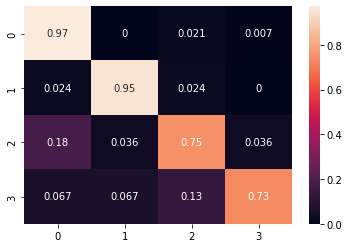

In [9]:

cm = confusion_matrix(y_act, y_pred)

sns.heatmap(cm / np.tile(np.sum(cm, axis=1), (4, 1)).T, annot=True)